<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Well-behaved-statistical-test" data-toc-modified-id="Well-behaved-statistical-test-1">Well-behaved statistical test</a></span></li></ul></div>

In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Well-behaved statistical test

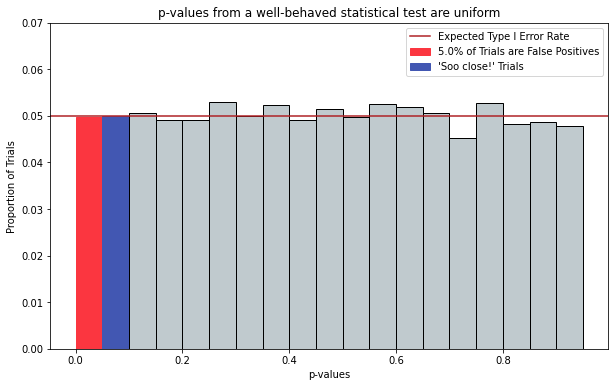

In [32]:
import numpy as np
from scipy import stats
from abra.vis import Gaussian, COLORS  # requires abracadabra
from matplotlib.patches import Rectangle

# Simulate multiple experimental datasets where H_0=True
# run t-tests, then collect the resulting p-values
ALPHA = 0.05
n_obs_per_trial, n_trials = 10, 10000
np.random.seed(1234)
null = Gaussian()
datasets = null.sample((2, n_obs_per_trial, n_trials))
pvals = stats.ttest_ind(datasets[0], datasets[1], axis=0).pvalue

def pval_rate_histogram(pvals, resolution=ALPHA, color='white', label=None):
    """Util for plotting the number of p-values that occur within buckets
    of size `resolution`.
    """
    bins = np.arange(0, 1, resolution)
    factor = 1 / float(len(pvals))
    cnts, bins = np.histogram(pvals, bins=bins)
    return plt.hist(bins[:-1], bins, weights=factor*cnts, color=color, label=label, edgecolor='black')

# Plot distribution of non-hacked p-values
plt.subplots(figsize=(10, 6))
cnt, bin_left, patches = pval_rate_histogram(pvals, color=COLORS.light_gray, label='p-values')
plt.ylim([0, .07])

# Highlight the p-values bucket associated with false positives
# and those trials that are "Soo close" to being "significant"
## Expected false positives (i.e. "significant")
expected_type_I = patches[0]
expected_type_I.set_color(COLORS.red)
expected_type_I_rate = cnt[0] * 100.
expected_type_I.set_label(f"{round(expected_type_I_rate)}% of Trials are False Positives")

## So close to being "significant"
near_type_I = patches[1]
near_type_I.set_color(COLORS.blue)
near_type_I.set_label("'Soo close!' Trials")
plt.axhline(ALPHA, color=COLORS.dark_red, label='Expected Type I Error Rate')
plt.xlabel('p-values')
plt.ylabel('Proportion of Trials')

plt.legend()
plt.title("p-values from a well-behaved statistical test are uniform")

savefig('/tmp/well-behaved-statistical-test.png', bbox_inches='tight', dpi=300)

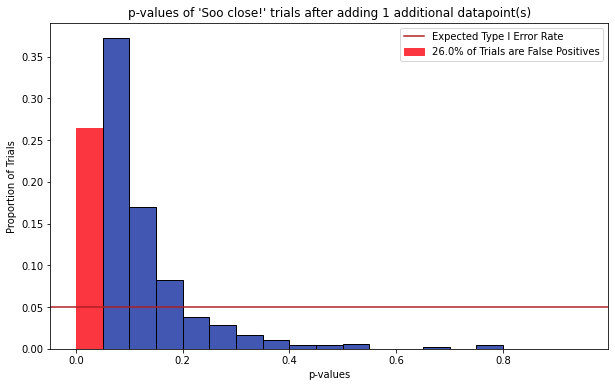

In [36]:
# Now hack the "So close" trials by adding samples to the H_0 dataset
## Identify the so-close trials and p-values
hack_index_mask = (pvals >= 0.05) & (pvals < .1)
hacked_datasets = datasets[:, :, hack_index_mask]
n_hacked_trials = hacked_datasets.shape[2]

## Add samples and re-run tests, collecting new p-values
n_additional_samples = 1
hacked_datasets = np.append(hacked_datasets, null.sample((2, n_additional_samples, n_hacked_trials)), axis=1)
hacked_pvals = stats.ttest_ind(hacked_datasets[0], hacked_datasets[1], axis=0).pvalue

# Display resulting hacked p-values distribution
plt.subplots(figsize=(10, 6))
hacked_cnt, hacked_bin_left, hacked_patches = pval_rate_histogram(hacked_pvals, color=COLORS.blue)
inflated_type_I = hacked_patches[0]
inflated_type_I.set_color(COLORS.red)
inflated_type_I_rate = 100. * hacked_cnt[0]
inflated_type_I.set_label(f"{round(inflated_type_I_rate)}% of Trials are False Positives")
plt.axhline(ALPHA, color=COLORS.dark_red, label='Expected Type I Error Rate')
plt.xlabel('p-values')
plt.ylabel('Proportion of Trials')

plt.legend()
plt.title(f"p-values of 'Soo close!' trials after adding {n_additional_samples} additional datapoint(s)")

savefig('/tmp/p-hacking-via-n-chasing.png', bbox_inches='tight', dpi=300)